<H2>GRaDE Rijn:</H2>
<UL>
    <LI> Onzekerheidsbanden meteo (jackknife) en HBV combineren
    </LI>
    <LI> Toepassen van de transformatie naar SOBEK
    </LI>
    <LI> Uitgeintegreerde werklijn
    </LI>
</UL>

In [1]:
import numpy as np
import os, sys, re
from math import *
import importlib as imp
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from tekal import *
from uitintegratie import *
import pandas as pd
import dill
import importlib as imp
import numpy.ma as ma
import fit_beta as fb
import fit_weibull as fw
from gumplot import *
import scipy.special as scs
import bisect
from IPython.lib.deepreload import reload as dreload
import inspect
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import gumplot as gplt

In [2]:
# Relevante herhaaltijden
Tretlist = [2,5,10,25,30,100,250,300,500,1000,1250,2500,3000,5000, 10000,20000,25000,30000,50000,100000]

In [3]:
# Tabel interpolatie
def interpolate(xx,yy,x,default=np.nan,fraction=-1):
    if x<xx[0] or x>xx[-1]:
        return default
    for i in range(len(xx)-1):
        if (x>=xx[i] and x<=xx[i+1]):
            if fraction<0.0:
                w=(x-xx[i])/(xx[i+1]-xx[i])   # use fraction=0.0 for yy[i] and fraction=1.0 for yy[i+1]
            else:
                w=fraction
            return (1.-w)*yy[i] + w*yy[i+1]

## Least-squares line fit
#def linfit(x,y):
#    nn = ma.count(x)
#    c = [(ma.sum(x*y)-ma.sum(x)*ma.sum(y)/nn)/(ma.sum(x*x)-ma.sum(x)*ma.sum(x)/nn)]
#    c.append((ma.sum(y)-c[0]*ma.sum(x))/nn)
#    return(c)

def linfit(xvec, yvec, wvec=None):
    if wvec is None:
        w = np.ones(len(xvec))
    else:
        w = wvec
    sw = ma.sum(w)
    sx = ma.sum(w*xvec)
    sy = ma.sum(w*yvec)
    sxx = ma.sum(w*xvec*xvec)
    sxy = ma.sum(w*xvec*yvec)   
    a = (sxy-sy*sx/sw)/(sxx-sx*sx/sw)
    b = (sy-a*sx)/sw
    return a,b

# lwrl based on a specified width
def lwrl(x,y,xtgt,width):
    pwr = 2.0
    xmax=np.max(x)
    xmin=np.min(x)
    ytgt = np.array([])
    for xx in xtgt:
        xxp = max(min(xx,xmax),xmin)
        mask = np.where(np.abs(x-xxp)<width)
        xsub = x[mask] - xxp
        ysub = y[mask]
        weights = (1.-(np.abs(xsub)/width)**pwr)**pwr
        a,b = linfit(xsub,ysub,weights)
        ytgt = np.append(ytgt,a*(xx-xxp) + b)
    return ytgt

def lower_exponential(x,a,b,lbnd,L):
    delta = (x-(L+lbnd-b)/a)
    if a*delta>0:
        y = a*x + b
    else:
        y = lbnd+L*np.exp(a/L*delta)
    return(y)

# Hulp routines voor de uitintegratie
def normal_cdf(x,parms):
    mu = parms[0]
    sigma = parms[1]
    return (1.0 + erf((x-mu) / sigma / sqrt(2.0))) / 2.0

def normal_pdf(x,parms):
    mu = parms[0]
    sigma = parms[1]
    return exp(-0.5*((x-mu)/2./sigma)**2)/(sigma*(2*pi)**0.5)

In [4]:
# outintegration with linear extrapolation in terms of the reduced gumbel variate
def outintegrateExtrap(parms, levels, distfun, n_extpt, n_intpt):
    # extrapolates the discharge curve beyond the highest point with npt points
    # the additional points are equally spaced on the F-axis between the highest F and 1
    # the additional parametersets are obtained by loglinear extrapolation from the 
    # highest npoints points in the data on the F-axis
    nparam = len(parms['distpar'][0])

    # fit the linear coefficients for each of the parameters
    list_a = []
    list_b = []
    for ipar in range(nparam):
        y = np.array([partuple[ipar] for partuple in parms['distpar']][-n_intpt:])
        F = np.array(parms['F'][-n_intpt:])
#       logt = np.log(1./(1.-F))     # fit linearly to the logarithm of the return period
#       a,b = linfit(sgv,y)
        sgv = -np.log(-np.log(F))    # fit linearly to the standarised gumbel variate
        a,b = linfit(sgv,y)
        list_a.append(a)
        list_b.append(b)

    # add a tuple of parameters and the F-value for points equally spaced between F_last and 1.0
    fhighest = parms['F'][-2]
    for ipt in range(n_extpt):
        ff_ipt = fhighest + (1.-fhighest)/(n_extpt+1)*(ipt+1)
#       logt_ipt = np.log(1./(1.-ff_ipt))
#       parms['distpar'].append(tuple([list_a[ipar]*logt_ipt+list_b[ipar] for ipar in range(nparam)]))
        sgv_ipt = -np.log(-np.log(ff_ipt))
        parms['distpar'].append(tuple([list_a[ipar]*sgv_ipt+list_b[ipar] for ipar in range(nparam)]))
        parms['F'] = np.append(parms['F'],ff_ipt)
    cdf = outintegrate(parms, levels, distfun)
    return cdf[cdf<1], levels[cdf<1]


<H3> Referentie werklijn en normale onzekerheid voor de Rijn, HBV-resultaten voor een optimal slice</H3>

In [5]:
# Lees de referentie werklijn voor de Rijn (2021)
with open('optimal_slice_mem6d_Fwet_500K_1951-2015_window61_part001-025_MAX.csv',"r") as fnin:
    qref = []
    minimum = 1000000.
    while True:
        line = fnin.readline()
        if not line:
            break
        syear, sqvalue = line.strip().split(',')
        try:
            year = int(syear)
            qvalue = float(sqvalue)
        except:
            continue
        bisect.insort(qref,qvalue)
nx = len(qref)
np_qref = np.array(qref)
np_sgv = -np.log(-np.log((np.array(list(range(nx)))+1.-0.3)/(nx+0.4)))

<h3>Regressie HBV-to-SOBEK Rijn</h3>
Uit regressie is een relatie bepaald uit de HBV-(piek)afvoeren $Q_h$ en de bijbehorende Sobek (piek)afvoeren $Q_s$ als volgt (Henk vd Boogaard, <tt>regression_2018</tt>):
    $$Q_s\,=\,C\,+\,r_1Q_h\,+\,(r_2-r_1)\sigma_1\log\left(1+\exp\left(\frac{Q_h-\mu_1}{\sigma_1}\right)\right)$$
    $$\phantom{Q_s\,=\,C\,+\,r_1Q_h\,}+\,(r_3-r_2)\,\sigma_2\log\left(1+\exp\left(\frac{Q_h-\mu_2}{\sigma_2}\right)\right)$$    
    $$\phantom{Q_s\,=\,C\,+\,r_1Q_h\,}+\,(r_4-r_3)\,\sigma_3\log\left(1+\exp\left(\frac{Q_h-\mu_3}{\sigma_3}\right)\right)$$
    $$\phantom{Q_s\,=\,C\,+\,r_1Q_h\,}+\,(r_5-r_4)\,\sigma_4\log\left(1+\exp\left(\frac{Q_h-\mu_4}{\sigma_4}\right)\right)$$

In [6]:
import math   # Crucial import !!!
def regression_2018(x, fit_regr=False):
    c      = 342.254390
    r1     = 0.91577902
    mu1    = 14442.2780 #ORIG
    sigma1 = 307.118620
    r2     = 0.32752076
    mu2    = 18573.2200 #ORIG
    sigma2 = 2.71804449E-14
    r3     = 0.53632634 #ORIG
    mu3    = 21904.1250 #ORIG
    sigma3 = 136.807970  
    r4     = 0.21296795
    mu4    = 26177.6500 #ORIG
    sigma4 = 79.5476640
    r5     = 0.00000000
    if fit_regr == True:
        mu1    = 14800.0000
        mu2    = 17750.0000
        r3     = 0.75000000
        mu3    = 20000.0000
    
    x_ = []
    for value in x:
        z1 = (value-mu1)/sigma1
        z2 = (value-mu2)/sigma2
        z3 = (value-mu3)/sigma3
        z4 = (value-mu4)/sigma4
        
        a1 = (r1*value)
        a2 = ((r2-r1)*sigma1*np.log(1+np.exp(z1)))
        try:
            a3 = ((r3-r2)*sigma2*np.log(1+math.exp(z2)))
        except:
            a3 = ((r3-r2)*sigma2*z2)
        a4 = ((r4-r3)*sigma3*np.log(1+np.exp(z3)))
        a5 = ((r5-r4)*sigma4*np.log(1+np.exp(z4)))
        
        y = c + a1 + a2 + a3 + a4 + a5
        x_.append(y)

    return x_

<H3> Onzekerheden (standaarddeviatie) behorende bij de werklijn: <br>
    Meteorologische (Jack-knife) en hydrologische (GLUE) onzekerheid gecombineerd</H3>

In [7]:
# Lees TEKAL file met Meteo onzekerheden
listTEKALBlocks("Final_FreqCurve_Rhine_HBV.tek")
# Lees TEKAL file (Henk vd Boogaard, met HBV onzekerheden)
UncMeteo = readTEKAL('Final_FreqCurve_Rhine_HBV.tek','BL01',skip=99)
tbl_mu_Meteo = UncMeteo[3]
tbl_sigma_Meteo = UncMeteo[5]

# Voeg de geinterpoleerde sigma's toe als onzekerheid
sigma_Meteo = []
for i in tqdm(list(range(np_qref.size))):
    sigma_Meteo.append(interpolate(tbl_mu_Meteo,tbl_sigma_Meteo,np_qref[i],default=10))
np_sigma_Meteo = np.array(sigma_Meteo)

rijn_new={'sgv':np_sgv,'mu':np_qref,'sigma':np_sigma_Meteo}

  0%|          | 0/50001 [00:00<?, ?it/s]

<H3> Log-lineaire extrapolatie van de werklijn + onzekerheid van 1250 jaar naar langere herhalingstijden.</h3>

Ook een transformatie naar SOBEK afvoeren d.m.v Regression2018 is uitgevoerd, zie afbeelding. Het is belangrijk dat de extrapolatie van de werklijn en onzekerheid vóór deze transformatie plaatsvindt.
</H3>

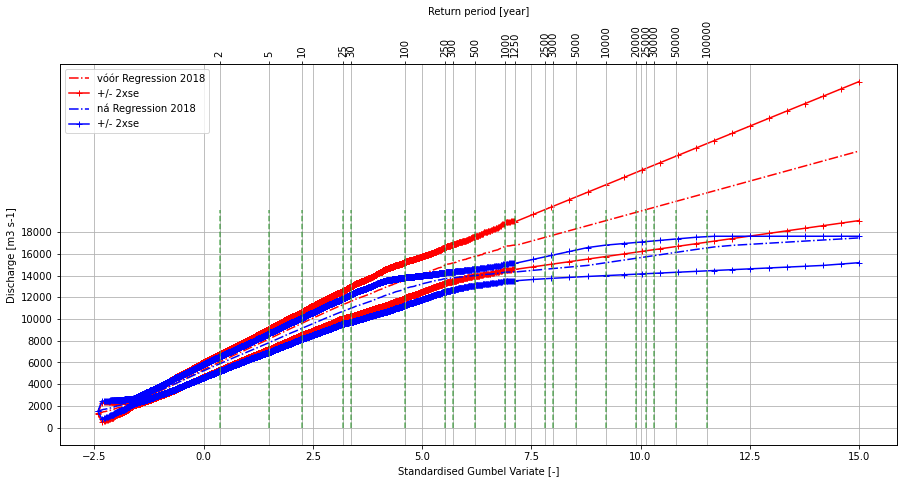

In [8]:
# Lineaire extrapolatie voor herhalingstijden boven de 1250 jaar
# van de 'HBV'- werklijn en de onzekerheid
Trmin = 1250 
Tr = 1./(1.-np.exp(-np.exp(-rijn_new['sgv'])))
mask = tuple([Tr>Trmin])
sgvmin = -np.log(-np.log(1.-1./Trmin))

a_mu, b_mu = linfit(rijn_new['sgv'][mask],rijn_new['mu'][mask])
a_sigma, b_sigma = linfit(rijn_new['sgv'][mask],rijn_new['sigma'][mask])

ymax = 20000 
yrange = 2000

sgvmax = 15
nsgv = 20
sgv_extrap = np.linspace(sgvmin,sgvmax,nsgv)
mu_extrap = sgv_extrap * a_mu + b_mu
sigma_extrap = sgv_extrap * a_sigma + b_sigma

mask = tuple([Tr<Trmin])
rijn_new_extrapolated = {}
rijn_new_extrapolated['sgv'] = np.concatenate((rijn_new['sgv'][mask], sgv_extrap))
rijn_new_extrapolated['mu'] = np.concatenate((rijn_new['mu'][mask], mu_extrap))
rijn_new_extrapolated['sigma'] = np.concatenate((rijn_new['sigma'][mask], sigma_extrap))

plt.plot(rijn_new_extrapolated['sgv'], rijn_new_extrapolated['mu'],'r-.',label='vóór Regression 2018')
plt.plot(rijn_new_extrapolated['sgv'], rijn_new_extrapolated['mu']+2*rijn_new_extrapolated['sigma'],'r+-', label='+/- 2xse')
plt.plot(rijn_new_extrapolated['sgv'], rijn_new_extrapolated['mu']-2*rijn_new_extrapolated['sigma'],'r+-')

plt.plot(rijn_new_extrapolated['sgv'], regression_2018(rijn_new_extrapolated['mu']),'b-.', label='ná Regression 2018')
plt.plot(rijn_new_extrapolated['sgv'], regression_2018(rijn_new_extrapolated['mu']+2*rijn_new_extrapolated['sigma']),'b+-', label='+/- 2xse')
plt.plot(rijn_new_extrapolated['sgv'], regression_2018(rijn_new_extrapolated['mu']-2*rijn_new_extrapolated['sigma']),'b+-')

ax=plt.gca()
fig=plt.gcf()
fig.set_size_inches(15,7)
ax.legend(loc="upper left")
gplt.add_gum_axis(Tretlist,ax,ymax,yrange)

<h3>Beschrijven van de hydraulische onzekerheid uit verstoorde SOBEK runs met de parameters van verdelingen</h3>

Voor elk van 50 events zijn 100 verschillende SOBEK simulaties gedraaid, elk met verstoorde parameters, 
om een maat te krijgen voor de onzekerheid in de hydraulische modellering (Latin-Hypercube). Voor elk van die 50 samples van elk 100 leden zijn hier de parameters geschat voor Beta, Normale en Uniforme verdeling. De Beta parameters zijn uiteindelijk niet gebruikt in deze berekening. Bij elke event hoort ook een referentie afvoer, dat is de SOBEK simulatie met onverstoorde parameters.

In [9]:
# Load ensembles into dictionaries
# Read the file into a dictionary, labelled by event->timeseries
datafile = 'read_Qmax_sums_results.csv'
sep = ';'
with open(datafile,"r") as fnin:
    line = fnin.readline().strip()
    colnames = re.sub(r'[^\x00-\x7F]','', line).split(sep)
    ensembles = { colname:[] for colname in colnames}
    while line:
        line = fnin.readline()
        linesplit = line.strip().split(sep)
        for i in range(len(linesplit)):
            if linesplit[i]:
                try:
                    ensembles[colnames[i]].append(float(linesplit[i].replace(',','.')))
                except:
                    ensembles[colnames[i]].append(linesplit[i])

# Select realizations from ensembles:
first_realization = 0
last_realization = 100
refnr = 113

label2nr = {}
rownames = ensembles['Scenario']
for i in range(len(rownames)):
    label2nr[rownames[i]] = i
selected = ['Sum%d'%dd for dd in range (first_realization,last_realization+1)]    # selected labels for realizations
selnr = [label2nr[rowname] for rowname in selected]

# Determine min, max, alpha, beta for each ensemble
irow_ref = label2nr['Sum%d'%refnr]
qref = np.array([])      # Referentie-afvoeren, met onverstoorde parameters
mu = np.array([])        # Gemiddelde van de afvoeren met verstoorde parameters, gegeven een de referentie afvoer
                         # deze zal nagenoeg gelijk zijn aan de referentie afvoer
sigma = np.array([])     # Standaardafwijking van de afvoeren met verstoorde parameters, gegeven een de referentie afvoer
minvalue = np.array([])  # Minimum van de afvoeren met verstoorde parameters, gegeven een de referentie afvoer
maxvalue = np.array([])  # Maximum van de afvoeren met verstoorde parameters, gegeven een de referentie afvoer

c0 = colnames.pop(0)
for icol in range(1,len(colnames)): 
    sample=np.array([ensembles[colnames[icol]][i] for i in selnr])
    qref = np.append(qref,ensembles[colnames[icol]][irow_ref])
    mu = np.append(mu,np.mean(sample))
    sigma = np.append(sigma,np.std(sample))
    minvalue = np.append(minvalue,np.min(sample))
    maxvalue = np.append(maxvalue,np.max(sample))
    

<h3>Beschrijven van de parameters als lineaire functies van de referentie afvoer</h3>

De boven afgeleide parameters van verdelingen voor elke event en bijbehorende referentie afvoer vormen een onregelmatig geheel. Om toch bruikbare parameters te krijgen voor een willekeurige referentie afvoer zijn lineaire verbanden gefit. 

In [10]:
# linear fits on the normal parameters mu and sigma
c_mu = linfit(qref,mu)
c_sigma = linfit(qref,sigma)

# linear fits on the uniform parameters min and max
c_min = linfit(qref,minvalue)
c_max = linfit(qref,maxvalue)

In [11]:
# gebaseerd op de uit LHS (SOBEK) exprimenten gevonden hydraulische onzekerheid
# geeft the verwachting en standaard deviatie van de SOBEK afvoer, als functie van de onverstoorde referentie afvoer
def hydraulic_uncertainty_uniform(qref):
    maxval_array = []
    minval_array = []
    for qr in qref:
        min_value = (-lower_exponential(qr,(1.0-c_min[0]), (-c_min[1]),0,250)
                           + qr)
        minval_array.append(min_value)
        max_value = (lower_exponential(qr,(c_max[0]-1.0), (c_max[1]),0,250)
                           + qr)
        maxval_array.append(max_value)
    return (np.array(minval_array),np.array(maxval_array))
    

## gebaseerd op de uit LHS (SOBEK) exprimenten gevonden hydraulische onzekerheid
## geeft the verwachting en standaard deviatie van de SOBEK afvoer, als functie van de onverstoorde referentie afvoer
def hydraulic_uncertainty_normal(qref):
    mu_array = []
    sgm_array = []
    for qr in qref:
        sgm_array.append(lower_exponential(qr,c_sigma[0],c_sigma[1],0,250))
        mu_array.append(lower_exponential(qr,c_mu[0],c_mu[1],0,10))
    return (np.array(mu_array),np.array(sgm_array))
    
# Plot betrouwbaarheidsband voor de hydraulische onzekerheid symmetrisch (LHS experiment)
qq = np.linspace(100,18000,1000)
qq_mu, qq_sgm = hydraulic_uncertainty_normal(qq)

 <h3>Simulatie van hydrologische en hydraulische onzekerheid</h3>
 De combinatie van onzekerhed door simulatie (opeenvolgende trekkingen). <br>
 De gevolgde werkwijze voor elke standardised gumbel variate $y$, oftewel voor elke herhalingstijd in een set: 
 <ul>   
 <li>Interpoleer uit de HBV-gebaseerde extremenplot de bijbehorende waarde van de afvoer én de standaard deviatie
 <li>  Jackknife + hydrologsche model onzekerheid -> $\mu_{hbv}(y)$, $\sigma_{hbv}(y)$
 <li>  Trek met deze parameters een normaal sample
 <li>  Voor élke $q_{hbv}$ uit dat sample:
 <ul>   
     <li> Transformeer naar een 'SOBEK' waarde $q_{hbv} \rightarrow q_{sbk}$ met <tt>Regression2018</tt>
   <li> Als functie van deze $q_{sbk}$, haal de $\mu_{sbk}$ en $\sigma_{sbk}$ in het geval van een normale benadering, of de min en max in het geval van de uniforme benadering.<br> Hiervoor wordt de lineaire fit gebruikt, maar wel met restricties: $\sigma_{sbk}\ge0$ en ${\rm min}\le\mu_{sbk}\le{\rm max}$.
   <li>Trek met de parameters een nieuwe waarde $q_{sbk}'$<br>
     (deze waarde bevat het nu effect van de hydaulische onzekerheid)
 </ul> 
 <li> Uit het sample van $q_{sbk}'$ waarden, fit een 3-parameter weibull verdeling
 </ul>

In [12]:
# Deze functie doet voor elke standardised gumbel variate y in de set stdgumvars het volgende: 
# * Interpoleert uit de HBV-gebaseerde extremenplot de bijbehorende waarde van de afvoer én de standaard deviatie
#   Jackknife + hydrologsche model onzekerheid -> mu_hbv, sigma_hbv
# * Trekt met de parameters mu_hbv en sigma_hbv een normaal sample
# * Voor élke q_hbv uit dat sample:
#   * Transformeer naar q_sobek
#   * als functie van deze q_sbk, haal de mu_sbk, sigma_sbk
#   * Trek met de parameters mu_sbk en sigma_sbk een nieuwe waarde q_sbk2
#     (deze waarde bevat het nu effect van de hydaulische onzekerheid)
# * Uit het sample van q_sbk2 waarden, fit een 3-parameter weibull verdeling

def sample_sbk_uniform(qsbk, sample_size):
    qq_minval, qq_maxval = hydraulic_uncertainty_uniform([qsbk])               # Bepaal normal parameters
    return np.random.uniform(low=qq_minval, high=qq_maxval, size=sample_size)   # trek hieruit een Normaal verdeelde sample

def sample_sbk_normal(qsbk, sample_size):
    qq_mu, qq_sgm = hydraulic_uncertainty_normal([qsbk])      # Bepaal normal parameters
    return np.random.normal(qq_mu, qq_sgm, sample_size)       # trek hieruit een Normaal verdeelde sample

def effective_sample_cascade(mu_hbv, sigma_hbv, sample_size, sample_func):
    # return the simulated sample of sobek discharges given the normal mu and sigma of the HBV-discharges only
    # this step takes into account the hydraulic uncertainty through the Beta distribution
    q_hbv = np.random.normal(mu_hbv,sigma_hbv,sample_size)# Trek een normaal sample met N(mu,sigma)
    q_sbk=regression_2018(q_hbv)                          # Transformeer dit sample met regression2018
    q_sbk0=regression_2018([mu_hbv])[0]                   # Transformeer gemiddelde met regression2018
    q_sbk2 = np.array([sample_func(qq,1)[0] for qq in q_sbk])
    return (q_sbk2)

def effective_sample(stdgumvars,rijndata,sample_size,sample_func):
#   sample_size = 10000
    mu = rijndata['mu']
    sgv = rijndata['sgv']
    sgm = rijndata['sigma']
    qsamples = []
    mu_sbk = []
    for y in stdgumvars:
        qhbv_mu = interpolate(sgv,mu,y)               # verwachtingswaarde uit HBV voor de gegeven herhalingstijd
        qhbv_sigma = interpolate(sgv,sgm,y)           # stddev uit HBV voor de gegeven herhalingstijd
        qsample = effective_sample_cascade(qhbv_mu, qhbv_sigma, sample_size, sample_func)
        mu_sbk.append(regression_2018([qhbv_mu])[0])  # Transformeer de mu(hbv) om de werklijn te krijgen        
        qsamples.append(qsample)
    return (mu_sbk, qsamples)


In [13]:
# Van de samples in het experiment, bepaal gemiddelden en standaardafwijking tegen de standardised gumbel variate 
# De gemiddelden zijn dan een nieuwe werklijn, en de standaard afwijking de onzekerheid rond de werklijn
sgvvals = np.concatenate((np.arange(-2,3.,step=0.2),np.arange(3.,15,step=0.5)))
size = 50000
mu_sbk_uni, qsamples_uni = effective_sample(sgvvals, rijn_new_extrapolated, size, sample_sbk_uniform)
qsmeanvar_uni = [(sgvvals[i],np.mean(qsamples_uni[i]),np.std(qsamples_uni[i])) for i in range(len(sgvvals))]
mu_sbk_uni, qsamples_norm = effective_sample(sgvvals, rijn_new_extrapolated, size, sample_sbk_normal)
qsmeanvar_norm = [(sgvvals[i],np.mean(qsamples_uni[i]),np.std(qsamples_norm[i])) for i in range(len(sgvvals))]

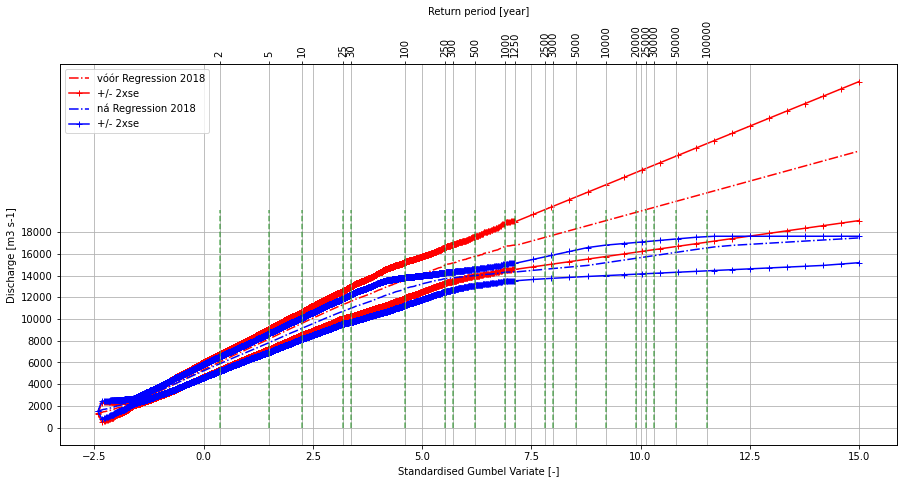

In [14]:
ymax = 20000 
yrange = 2000

plt.plot(rijn_new_extrapolated['sgv'], rijn_new_extrapolated['mu'],'r-.',label='vóór Regression 2018')
plt.plot(rijn_new_extrapolated['sgv'], rijn_new_extrapolated['mu']+2*rijn_new_extrapolated['sigma'],'r+-', label='+/- 2xse')
plt.plot(rijn_new_extrapolated['sgv'], rijn_new_extrapolated['mu']-2*rijn_new_extrapolated['sigma'],'r+-')

plt.plot(rijn_new_extrapolated['sgv'], regression_2018(rijn_new_extrapolated['mu']),'b-.', label='ná Regression 2018')
plt.plot(rijn_new_extrapolated['sgv'], regression_2018(rijn_new_extrapolated['mu']+2*rijn_new_extrapolated['sigma']),'b+-', label='+/- 2xse')
plt.plot(rijn_new_extrapolated['sgv'], regression_2018(rijn_new_extrapolated['mu']-2*rijn_new_extrapolated['sigma']),'b+-')

ax=plt.gca()
fig=plt.gcf()
fig.set_size_inches(15,7)
ax.legend(loc="upper left")
gplt.add_gum_axis(Tretlist,ax,ymax,yrange)

In [15]:
# HydraRing parameters moeten gegeven zijn als functie van de referntie(=werklijn) afvoer, in dit geval het gemiddelde
# In de volgorde schaal, vorm, locatie voor de Weibull verdeling
# De referentie afvoer moet ervan zijn afgetrokken, zodat die door HydraRing kan worden bijgeteld

fpar = open('werklijn.txt','w')
fpar.write("%11s, %11s, %11s\n"%('StdGumVar', 'Herhaaltijd', 'Afvoer [m3/s]'))
for (sgv, mu_s) in zip(sgvvals, mu_sbk_uni):
    fpar.write("%11.3f, %11.3f, %11.3f\n"%(sgv,1./(1.-np.exp(-np.exp(-sgv))),mu_s))
fpar.close()

<h3>Uitintegratie van de totale onzekerheid</h3>

In [16]:
def outintegrate(parms, levels, distfun):
    # based on a numerical integral over q probabilities
    # this works if we have an ordered set (in terms of reference q) in parms, each with its non-exceedance probability
    # each record in parms consists of a tuple of parameters AND an associated non-exceedance probability
    # has to be ordered on reference Q (that also means ordered by non-exceedance probability) 
    nx = len(parms['F'])
    nl = len(levels)
    cdf = np.array([0.0]*nl)
    H = parms['F']
    wtsum = 0.0
#   for i in range(nx):
    for i in tqdm(list(range(nx))):
        if i==0:
            wt = 0.5*(H[0]+H[1])
        elif i==nx-1:
            wt = 1.-0.5*(H[nx-1]+H[nx-2])
        else:
            wt = 0.5*(H[i+1]-H[i-1])
        wtsum = wtsum + wt
        distribution = all_distributions(distfun, parms['distpar'][i], levels)
        cdf += distribution * wt
    return cdf

# outintegration with linear extrapolation in terms of the reduced gumbel variate
def outintegrateExtrap(parms, levels, distfun, n_extpt, n_intpt):
    # extrapolates the discharge curve beyond the highest point with npt points
    # the additional points are equally spaced on the F-axis between the highest F and 1
    # the additional parametersets are obtained by loglinear extrapolation from the 
    # highest npoints points in the data on the F-axis
    nparam = len(parms['distpar'][0])

    # fit the linear coefficients for each of the parameters
    list_a = []
    list_b = []
    for ipar in range(nparam):
        y = np.array([partuple[ipar] for partuple in parms['distpar']][-n_intpt:])
        F = np.array(parms['F'][-n_intpt:])
#       logt = np.log(1./(1.-F))     # fit linearly to the logarithm of the return period
#       a,b = linfit(sgv,y)
        sgv = -np.log(-np.log(F))    # fit linearly to the standarised gumbel variate
        a,b = linfit(sgv,y)
        list_a.append(a)
        list_b.append(b)

    # add a tuple of parameters and the F-value for points equally spaced between F_last and 1.0
    fhighest = parms['F'][-2]
    for ipt in range(n_extpt):
        ff_ipt = fhighest + (1.-fhighest)/(n_extpt+1)*(ipt+1)
#       logt_ipt = np.log(1./(1.-ff_ipt))
#       parms['distpar'].append(tuple([list_a[ipar]*logt_ipt+list_b[ipar] for ipar in range(nparam)]))
        sgv_ipt = -np.log(-np.log(ff_ipt))
        parms['distpar'].append(tuple([list_a[ipar]*sgv_ipt+list_b[ipar] for ipar in range(nparam)]))
        parms['F'] = np.append(parms['F'],ff_ipt)
    cdf = outintegrate(parms, levels, distfun)
    return cdf[(cdf-1.0)*cdf<0], levels[(cdf-1.0)*cdf<0]

In [17]:
# Uitintegratie Normal MET extrapolatie
imp.reload(fb)
levels = np.array(list(range(200,20000,50)))

qs0 = np.array([qs[0] for qs in qsmeanvar_norm])
qs1 = np.array([qs[1] for qs in qsmeanvar_norm])
qs2 = np.array([qs[2] for qs in qsmeanvar_norm])

rijn_parms = {'distpar':[], 'F':np.array([])}
for Tr in Tretlist:
    sgv = -np.log(-np.log(1.-1./Tr))
    mu  =  interpolate(qs0,qs1,sgv)
    sigma_vs_sgv = interpolate(qs0,qs2,sgv)   # sigma as a function of standardized gumbel variate
    rijn_parms['distpar'].append((mu, sigma_vs_sgv))
    rijn_parms['F']=np.append(rijn_parms['F'],1.-1./Tr)
rijn_cdf_norm1, rijn_levels_norm1 = outintegrateExtrap(rijn_parms, levels, normal_cdf, 50, 10)
rijn_sgv_norm1 = -np.log(-np.log(rijn_cdf_norm1))

rijn_parms = {'distpar':[], 'F':np.array([])}
for Tr in Tretlist:
    sgv = -np.log(-np.log(1.-1./Tr))
    mu  =  interpolate(qs0,qs1,sgv)
    sigma_vs_mu = interpolate(qs1,qs2,mu)    # sigma as a function of mu (as it is in HydraRing)
    rijn_parms['distpar'].append((mu, sigma_vs_mu))
    rijn_parms['F']=np.append(rijn_parms['F'],1.-1./Tr)
rijn_cdf_norm2, rijn_levels_norm2 = outintegrateExtrap(rijn_parms, levels, normal_cdf, 50, 10)
rijn_sgv_norm2 = -np.log(-np.log(rijn_cdf_norm2))

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000

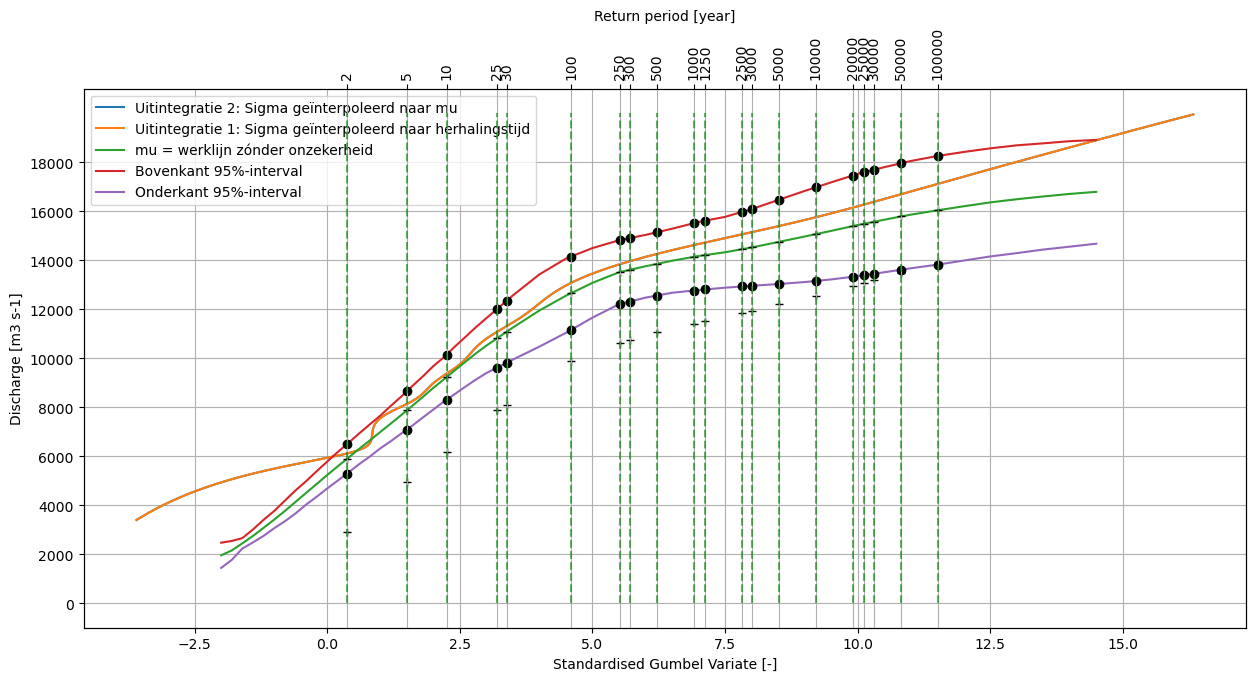

In [123]:
plt.plot(rijn_sgv_norm1,rijn_levels_norm2,label='Uitintegratie 2: Sigma geïnterpoleerd naar mu')
plt.plot(rijn_sgv_norm2,rijn_levels_norm1,label='Uitintegratie 1: Sigma geïnterpoleerd naar herhalingstijd')

plt.plot(qs0,qs1,label='mu = werklijn zónder onzekerheid')
plt.plot(qs0,qs1+1.96*qs2,label='Bovenkant 95%-interval')
plt.plot(qs0,qs1-1.96*qs2,label='Onderkant 95%-interval')

# Tabel
selected_Tr = {'sgv':[], 'mu':[], 'sigma':[], 'outint':[]}
for Tr in Tretlist:
    sgv = -np.log(-np.log(1.-1./Tr))
    mu  =  interpolate(qs0,qs1,sgv)
    sigma_vs_mu = interpolate(qs1,qs2,mu)
    outint = interpolate(rijn_sgv_norm2,levels,sgv)
    
    selected_Tr['sgv'].append(sgv)
    selected_Tr['mu'].append(mu)
    selected_Tr['sigma'].append(sigma_vs_mu)
    selected_Tr['outint'].append(outint)
    print("%10d, %10.3f, %10.3f, %10.3f"%(Tr,mu,sigma_vs_mu,outint))

np_selected_Tr = {}
np_selected_Tr['sgv'] = np.array(selected_Tr['sgv'])
np_selected_Tr['mu'] = np.array(selected_Tr['mu'])
np_selected_Tr['sigma'] = np.array(selected_Tr['sigma'])
np_selected_Tr['outint'] = np.array(selected_Tr['outint'])
     
plt.plot(np_selected_Tr['sgv'],np_selected_Tr['outint'],'k+')
plt.plot(np_selected_Tr['sgv'],np_selected_Tr['mu'],'k+')
plt.plot(np_selected_Tr['sgv'],np_selected_Tr['mu']+1.96*np_selected_Tr['sigma'],'ko',\
         np_selected_Tr['sgv'],np_selected_Tr['mu']-1.96*np_selected_Tr['sigma'],'ko')
ax=plt.gca()
fig=plt.gcf()
fig.set_size_inches(15,7)
ax.legend(loc="upper left")
gplt.add_gum_axis(Tretlist,ax,ymax,yrange)

<h2>Analytische benadering á la Henk van den Boogaard</h2>
We take $n+1$ support points $\left(y_i,Q_i\right)$, which are not located on the curve, but are connected by the tangents best approximating the curve (i.e. piecewise-linear approximation, but we connect the pieces exponentially).
$$
Q(y)\,=\,C\,+\,r_1y\,+\,\sum\limits_{i=1}^{n-1}
\left(r_{i+1}-r_i\right)
s_i
\log
\left(
1\,+\,\exp\left(\frac{y-y_i}{s_i}\right)
\right)
$$

$$
Q(y)\,=\,Q_0\,+\,r_1\left(y-y_0\right)\,+\,\sum\limits_{i=1}^{n-1}
A_i\log
\left(
1\,+\,\exp\left(\frac{y-y_i}{s_i}\right)
\right)
$$

The $r_i$ is the slope of the line connecting points $i-1$ and $i$:
$$
r_i\,=\,\frac{Q_i\,-\,Q_{i-1}}{y_i\,-\,y_{i-1}}
$$

hence,
$$
A_i
\,=\,
\left(r_{i+1}\,-\,r_i\right)\,s_i
\,=\,
\left(
\frac{Q_{i+1}\,-\,Q_i}{y_{i+1}\,-\,y_i}\,-\,\frac{Q_i\,-\,Q_{i-1}}{y_i\,-\,y_{i-1}}
\right)\,s_i
$$

and $s_i$ is related to the second derivative in the point $\left(y_i,Q_i\right)$:
$$
s_i\,=\,\frac 1 4 \left(\frac{d^2 Q}{dy^2}\right)^{-1}_{y=y_0}\,\left(r_{i+1}-r_i\right)
$$


In [93]:
def expsum(x,sup_x,sup_y,sup_A,sup_s):
    qval = sup_y[0] + sup_A[0] * (x-sup_x[0])
    for i in range(1,len(sup_A)):
        qval = qval + sup_A[i]*np.log(1.+np.exp((x-sup_x[i])/sup_s[i]))
    return(qval)

def expsum_parameters(xx,yy,sup_x,sup_y,sup_r,w=4):
    r1 = (sup_y[1]-sup_y[0])/(sup_x[1]-sup_x[0])
    sup_s = [0]
    sup_A = [r1]
    for i in range(1,len(sup_x)-1):
        ndx = np.argmin(xx<sup_x[i]) # index for this threshold value
        a,b,c = np.polyfit(xx[ndx-w:ndx+w],yy[ndx-w:ndx+w],deg=2)   # local quadratic fit
        second_derivative = 2*a 
        delta_r = (sup_y[i+1]-sup_y[i])/(sup_x[i+1]-sup_x[i]) - (sup_y[i]-sup_y[i-1])/(sup_x[i]-sup_x[i-1])
#       s = abs(delta_r/4./second_derivative)
        s = sup_r[i]
        sup_s.append(s)
        sup_A.append(delta_r*sup_r[i])
    return(sup_A, sup_s, r1)
    

def expsum_latex_excell(sup_x,sup_y,sup_A,sup_s,function_name,xname='x',yname='y'):
    i = 1
    # print the latex expression:
    print ('LaTEX:')
    latex = "%s(%s)\\,=\\,%.3f\,+\,%.3d\left(%s-%.3f\\right)"%(yname,xname,sup_y[0],sup_A[0],xname,sup_x[0])
    for i in range(1,len(sup_x)-1):
        latex = latex + "\\,+\\,%.3f\\log\\left(1+\\exp\\left(\\frac{%s-%.3f}{%.3f}\\right)\\right)"%(sup_A[i],xname,sup_x[i],sup_s[i])
    latex = re.sub(r"\+(\\,)*-","-",latex)
    print(latex)
    print()
    # print the excell expression:
    print ('VBA:')
    print("Function %s(x)"%function_name)                 
    print( re.sub(r"\+[\s\t]*-","-", "   res = %.3e + %.3e * (x - %.3e)"%(sup_y[0],sup_A[0],sup_x[0])))
    for i in range(1,len(sup_x)-1):
        print(re.sub(r"\+[\s\t]*-","-","   res = res + %.3e * Log(1.+Exp((x - %.3e)/%.3e))"%(sup_A[i],sup_x[i],sup_s[i])))
    print("   %s = res"%function_name)    
    print("End Function")                 


LaTEX:
Q(y)\,=\,5500.000\,+\,1777\left(y-0.000\right)\,-766.667\log\left(1+\exp\left(\frac{y-4.500}{0.600}\right)\right)\,+\,41.667\log\left(1+\exp\left(\frac{y-9.000}{1.000}\right)\right)\,+\,145.833\log\left(1+\exp\left(\frac{y-15.000}{1.000}\right)\right)

VBA:
Function Werklijn_met_onzekerheid(x)
   res = 5.500e+03 + 1.778e+03 * (x - 0.000e+00)
   res = res -7.667e+02 * Log(1.+Exp((x - 4.500e+00)/6.000e-01))
   res = res + 4.167e+01 * Log(1.+Exp((x - 9.000e+00)/1.000e+00))
   res = res + 1.458e+02 * Log(1.+Exp((x - 1.500e+01)/1.000e+00))
   Werklijn_met_onzekerheid = res
End Function


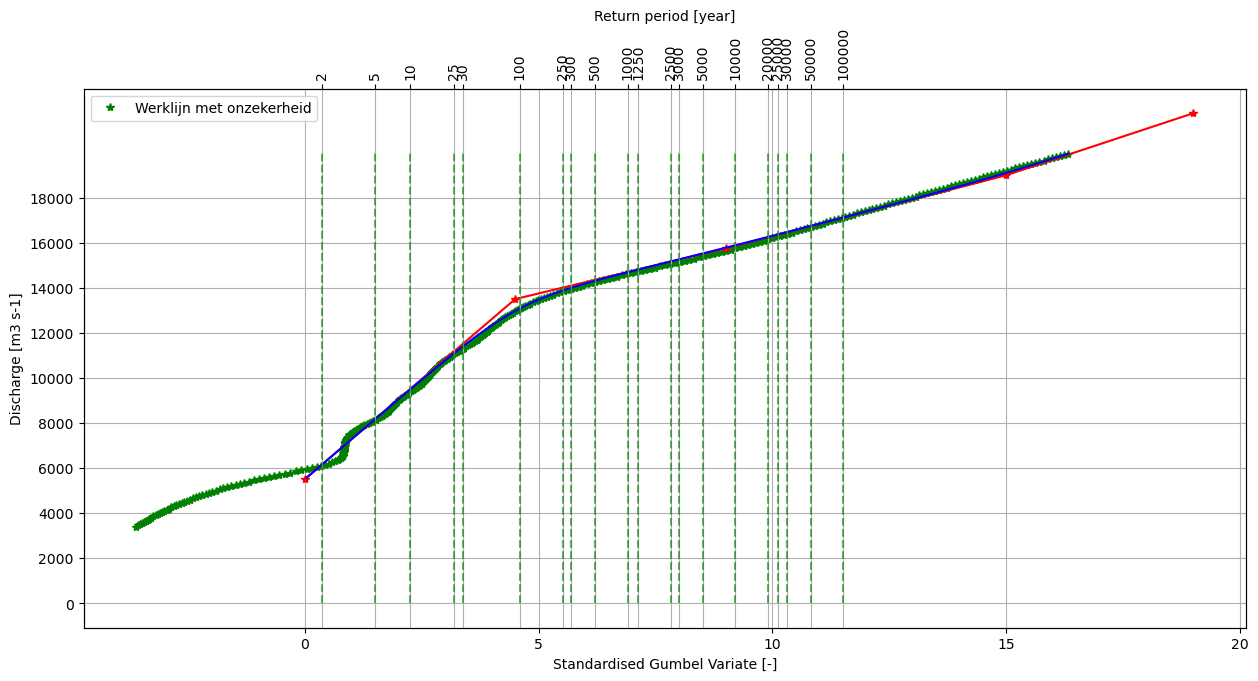

In [72]:
# Q as a function of the standardised gumbel variate
#sup_y = [0, 4.5, 9, 15, 19]
#sup_Q = [5500, 13500, 15750, 19000, 21750]
sup_y = [0, 4.5, 9, 15, 19]
sup_Q = [5500, 13500, 15750, 19000, 21750]
sup_r = [1, 0.6, 1, 1, 1]
naam = 'Werklijn met onzekerheid'

sup_A, sup_s, r1 = expsum_parameters(rijn_sgv_norm1,rijn_levels_norm1,sup_y,sup_Q,sup_r,w=3)     

plt.plot(rijn_sgv_norm1,rijn_levels_norm1,'g*',label=naam)
plt.plot(sup_y,sup_Q,'r*-')

# evaluate the approximation for every point in the original set:
rijn_sgv_approx = rijn_sgv_norm1[rijn_sgv_norm1>sup_y[0]]
rijn_levels_approx = [expsum(y,sup_y,sup_Q,sup_A,sup_s) for y in rijn_sgv_approx]
plt.plot(rijn_sgv_approx,rijn_levels_approx,'b-')

ax=plt.gca()
fig=plt.gcf()
fig.set_size_inches(15,7)
ax.legend(loc="upper left")
gplt.add_gum_axis(Tretlist,ax,ymax,yrange)
expsum_latex_excell(sup_y,sup_Q,sup_A,sup_s,re.sub("\s+","_",naam),xname='y',yname='Q')

LaTEX:
Q(y)\,=\,5250.000\,+\,1700\left(y-0.000\right)\,-1036.000\log\left(1+\exp\left(\frac{y-5.000}{0.700}\right)\right)\,+\,82.000\log\left(1+\exp\left(\frac{y-7.500}{0.400}\right)\right)\,-196.429\log\left(1+\exp\left(\frac{y-11.500}{1.000}\right)\right)

VBA:
Function Werklijn_zonder_onzekerheid(x)
   res = 5.250e+03 + 1.700e+03 * (x - 0.000e+00)
   res = res -1.036e+03 * Log(1.+Exp((x - 5.000e+00)/7.000e-01))
   res = res + 8.200e+01 * Log(1.+Exp((x - 7.500e+00)/4.000e-01))
   res = res -1.964e+02 * Log(1.+Exp((x - 1.150e+01)/1.000e+00))
   Werklijn_zonder_onzekerheid = res
End Function


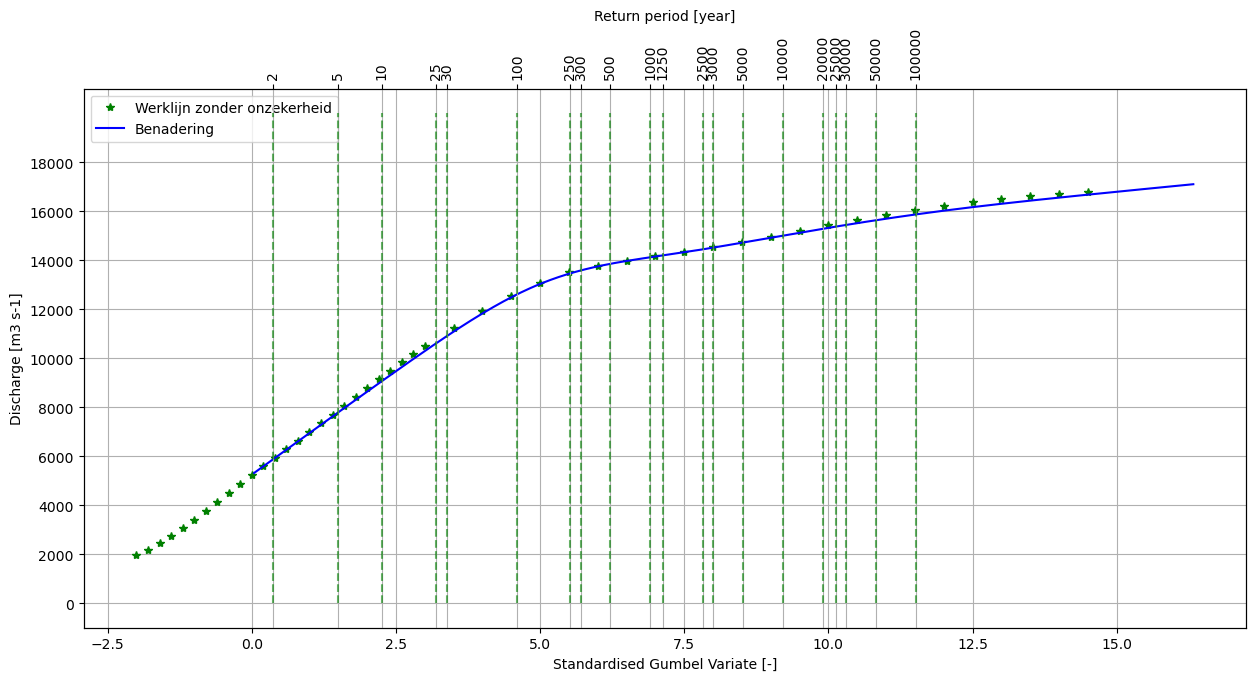

In [119]:
# Q as a function of the standardised gumbel variate
sup_y = [0, 5, 7.5, 11.5, 15]
sup_Q = [5250, 13750, 14300, 16000, 16800]
sup_r = [1, 0.7, 0.4, 1, 1]
#sup_y = [0, 3, 5, 11.5, 15]
#sup_Q = [5250, 10500, 13750, 16000, 16800]
naam = 'Werklijn zonder onzekerheid'
sup_A, sup_s, r1 = expsum_parameters(qs0,qs1,sup_y,sup_Q,sup_r,w=6)

plt.plot(qs0,qs1,'g*',label=naam)
# plt.plot(sup_y,sup_Q,'r*-')

# evaluate the approximation for every point in the original set:
rijn_sgv_approx = rijn_sgv_norm1[rijn_sgv_norm1>sup_y[0]]
rijn_levels_approx = [expsum(y,sup_y,sup_Q,sup_A,sup_s) for y in rijn_sgv_approx]
plt.plot(rijn_sgv_approx,rijn_levels_approx,'b-', label="Benadering")

ax=plt.gca()
fig=plt.gcf()
fig.set_size_inches(15,7)
ax.legend(loc="upper left")
gplt.add_gum_axis(Tretlist,ax,ymax,yrange)
expsum_latex_excell(sup_y,sup_Q,sup_A,sup_s,re.sub("\s+","_",naam),xname='y',yname='Q')

LaTEX:
y(Q)\,=\,0.000\,+\,000\left(Q-5500.000\right)\,+\,0.819\log\left(1+\exp\left(\frac{Q-13500.000}{500.000}\right)\right)\,-0.319\log\left(1+\exp\left(\frac{Q-16000.000}{500.000}\right)\right)

VBA:
Function Inverse_Werklijn_met_onzekerheid(x)
   res = 0.000e+00 + 5.625e-04 * (x - 5.500e+03)
   res = res + 8.188e-01 * Log(1.+Exp((x - 1.350e+04)/5.000e+02))
   res = res -3.188e-01 * Log(1.+Exp((x - 1.600e+04)/5.000e+02))
   Inverse_Werklijn_met_onzekerheid = res
End Function


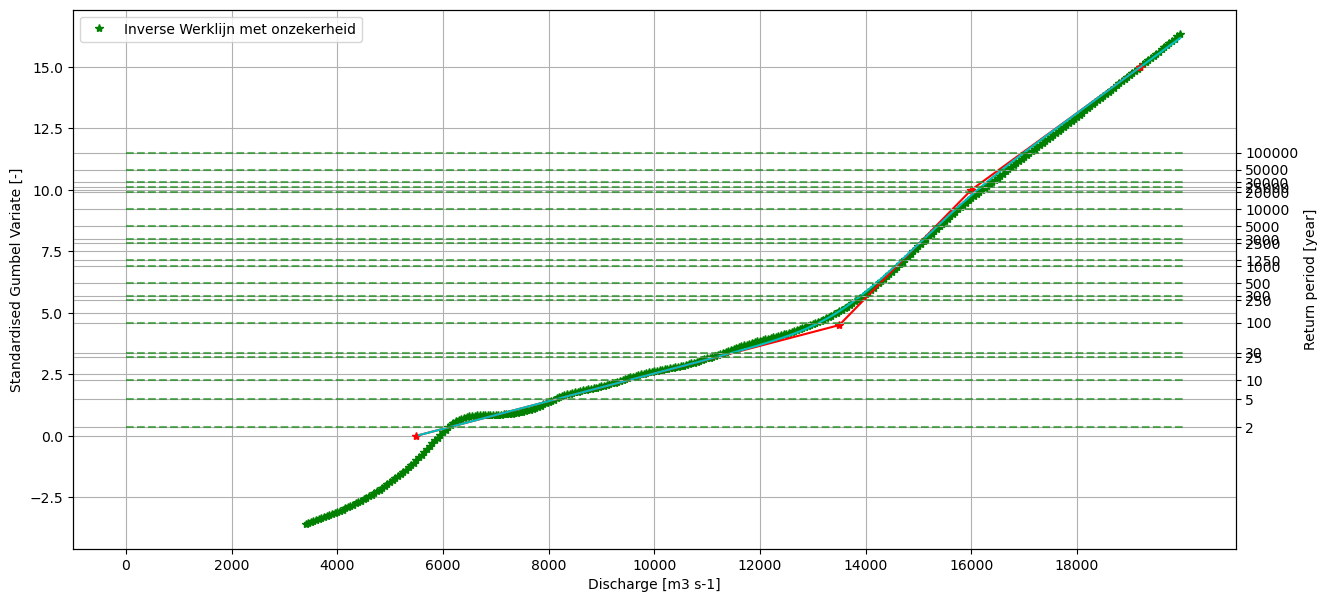

In [111]:
# the standardised gumbel variate as function of Q
sup_y = [0, 4.5, 10, 15]
sup_Q = [5500, 13500, 16000, 19200]
sup_r = [500,500,500]
naam = 'Inverse Werklijn met onzekerheid'
w = 3

sup_A, sup_s, r1 = expsum_parameters(rijn_levels_norm1,rijn_sgv_norm1,sup_Q,sup_y,sup_r)

plt.plot(rijn_levels_norm1,rijn_sgv_norm1,'g*',label=naam)
plt.plot(sup_Q,sup_y,'r*-')

# evaluate the approximation for every point in the original set:
rijn_levels_approx = rijn_levels_norm2[rijn_levels_norm2>sup_Q[0]]
rijn_sgv_approx = np.array([expsum(Q,sup_Q,sup_y,sup_A,sup_s) for Q in rijn_levels_approx])
selection = (rijn_sgv_approx<20)
plt.plot(rijn_levels_approx[selection],rijn_sgv_approx[selection],'c-')

ax=plt.gca()
fig=plt.gcf()
fig.set_size_inches(15,7)
ax.legend(loc="upper left")
gplt.add_gum_axis_vert(Tretlist,ax,ymax,yrange)
expsum_latex_excell(sup_Q,sup_y,sup_A,sup_s,re.sub("\s+","_",naam),xname='Q',yname='y')

LaTEX:
y(Q)\,=\,0.000\,+\,000\left(Q-5250.000\right)\,+\,1.591\log\left(1+\exp\left(\frac{Q-13500.000}{750.000}\right)\right)\,+\,0.717\log\left(1+\exp\left(\frac{Q-16500.000}{200.000}\right)\right)

VBA:
Function Inverse_Werklijn_zonder_onzekerheid(x)
   res = 0.000e+00 + 5.455e-04 * (x - 5.250e+03)
   res = res + 1.591e+00 * Log(1.+Exp((x - 1.350e+04)/7.500e+02))
   res = res + 7.167e-01 * Log(1.+Exp((x - 1.650e+04)/2.000e+02))
   Inverse_Werklijn_zonder_onzekerheid = res
End Function


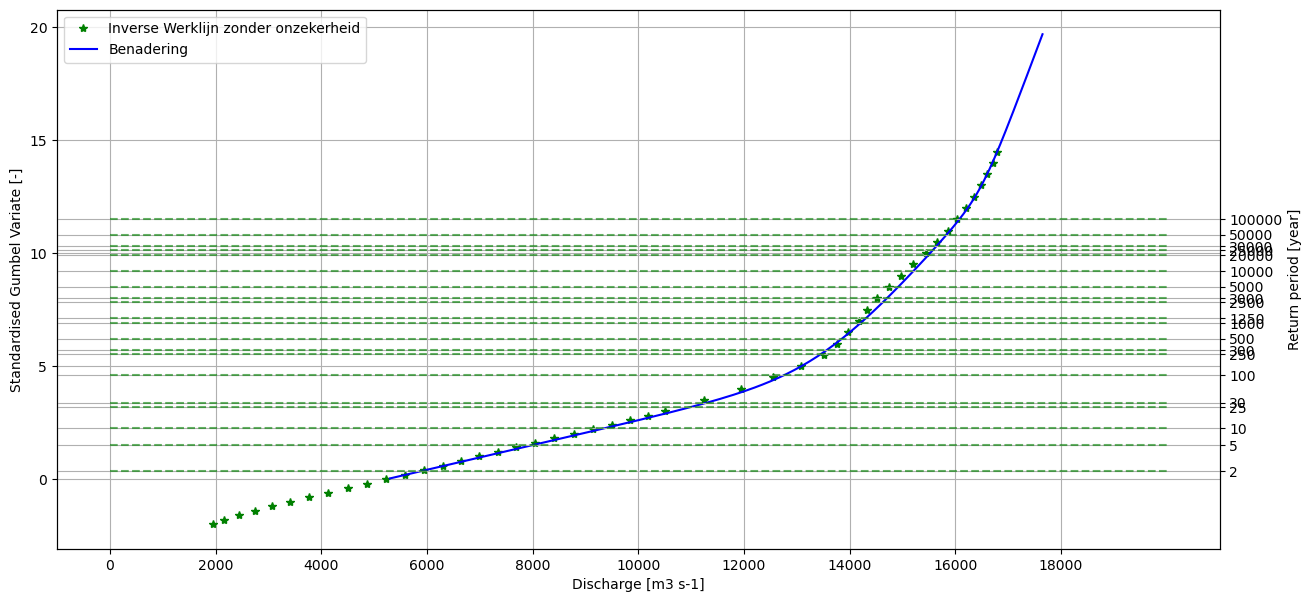

In [118]:
# the standardised gumbel variate as function of Q
sup_y = [0, 4.5, 12.5, 15]
sup_Q = [5250, 13500, 16500, 16900]
sup_r = [200, 750, 200]
#sup_y = [0, 4.5, 11.5, 15]
#sup_Q = [5250, 13000, 16000, 16800]

naam = 'Inverse Werklijn zonder onzekerheid'
sup_A, sup_s, r1 = expsum_parameters(qs1,qs0,sup_Q,sup_y,sup_r,w=2)

plt.plot(qs1,qs0,'g*',label=naam)
# plt.plot(sup_Q,sup_y,'r*-')    # lines between support points

# evaluate the approximation for every point in the original set:
rijn_levels_approx = rijn_levels_norm1[(rijn_levels_norm1>sup_Q[0])]
rijn_sgv_approx = np.array([expsum(Q,sup_Q,sup_y,sup_A,sup_s) for Q in rijn_levels_approx])
selection = (rijn_sgv_approx<20)
plt.plot(rijn_levels_approx[selection],rijn_sgv_approx[selection],'b-', label='Benadering')

ax=plt.gca()
fig=plt.gcf()
fig.set_size_inches(15,7)
ax.legend(loc="upper left")
gplt.add_gum_axis_vert(Tretlist,ax,ymax,yrange)

expsum_latex_excell(sup_Q,sup_y,sup_A,sup_s, re.sub("\s+","_",naam),xname='Q',yname='y')

###### <h2>Scenarios</h2>

In [ ]:
infile =r"read_Qmax_sums_results.csv"

df = pd.read_csv(infile, sep=';', index_col=0)
df.dropna(inplace=True)

ref = df.loc[['Sum113']]

scenarios = ['Sum101','Sum102','Sum103',
             'Sum104','Sum105','Sum106',
             'Sum107','Sum108','Sum109',
             'Sum110','Sum111','Sum112',]

x_start = pd.Series(np.arange(250,12500,250))
y_start = pd.Series(np.arange(250,12500,250))

func = []
for scenario in scenarios:
    fig1, ax1 = plt.subplots(figsize=(12,6))
    scenA = df.loc[[scenario]]
    
    df2 = pd.concat([ref, scenA], axis=0).T
    x = df2['Sum113'].sort_values()
    y = df2[scenario].sort_values()
    
    x = pd.concat([x_start, x], axis=0)
    x.reindex()
    y = pd.concat([y_start, y], axis=0)
    
    z = np.polyfit(x, y, 3)
    f = np.poly1d(z)
    func.append(f)
    
    # calculate new x's and y's
    x_new = np.linspace(x.iloc[0], x.iloc[-1], 50)
    y_new = f(x_new)
    
    ax1.plot(x,y, 'ro', label=scenario)
    ax1.plot(x_new,y_new, 'r', label=scenario + "_fit")

    ax1.plot([0,20000],[0,20000], 'k--')  
    ax1.set_xlim(10000,20000)
    ax1.set_ylim(10000,)
    plt.legend()
    # plt.savefig(f"{scenario}_linfit.png", dpi=150, bbox_inches='tight')

In [ ]:
fig1, ax1 = plt.subplots(figsize=(12,6))

colors = ['blue','orange','red']
for scenario, color in zip(scenarios[0:3], colors):
    
    scenA = df.loc[[scenario]]
    
    df2 = pd.concat([ref, scenA], axis=0).T
    x = df2['Sum113'].sort_values()
    y = df2[scenario].sort_values()
    
    x = pd.concat([x_start, x], axis=0)
    x.reindex()
    y = pd.concat([y_start, y], axis=0)
    
    z = np.polyfit(x, y, 5)
    f = np.poly1d(z)
    func.append(f)
    
    # calculate new x's and y's
    x_new = np.linspace(x.iloc[0], x.iloc[-1], 50)
    y_new = f(x_new)
    
    ax1.scatter(x,y, marker = 'o', color=color, label=scenario)
    ax1.plot(x_new,y_new, color=color, label=scenario + "_fit")

ax1.plot([0,20000],[0,20000], 'k--')  
ax1.set_xlim(10000,20000)
# ax1.set_ylim(13500,20000)
# ax1.set_xlim(0,20000)
ax1.set_ylim(10000,)
plt.legend()
#plt.savefig(f"{scenario}_allinone.png", dpi=150, bbox_inches='tight')

In [ ]:
#plot oud versus observations
fig, ax = plt.subplots(1,1)
ax.set_xlim(0.325,12)
ymax = 20000 
yrange = 500
ax.set_ylim(0,ymax)

ax.set_xlim(8,12)
ax.set_ylim(14000,17000)

scenarios = ['Sum101','Sum102','Sum103']

for scenario in scenarios:
#scenario = 'Sum102'

    scenA = df.loc[[scenario]]

    df2['Sum113']

    df2 = pd.concat([ref, scenA], axis=0).T
    x = df2['Sum113'].sort_values()
    y = df2[scenario].sort_values()

    x = pd.concat([x_start, x], axis=0)
    x.reindex()
    y = pd.concat([y_start, y], axis=0)

    z = np.polyfit(x, y, 5)
    f = np.poly1d(z)
    func.append(f)

    np_mean_new = f(np_mean)

    ax.plot(np_yy[np_mean_new>13000],np_mean_new[np_mean_new>13000],linestyle='--',label="GRADE'21 - %s" %(scenario))

ax.plot(np_yy,np_mean,'b-',label="GRADE'21")
ax.plot(rijn_obs['sgv'],rijn_obs['mu'],'g*',label="Observations")

ax=plt.gca()
fig=plt.gcf()
fig.set_size_inches(15,7)
ax.legend(loc="upper left")
add_gum_axis(Tretlist,ax,ymax,yrange)
plt.savefig('plots//plot_10_all_zoom.png', dpi=150, bbox_inches='tight')
